# Face Identification

Output vector: **16** x float32  
Dataset size: **20** / 2194  

In [1]:
!pip install cloud-tpu-client==0.10 torch==1.12.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.12-cp37-cp37m-linux_x86_64.whl torchvision

     |████████████████████████████████| 187.4 MB 20 kB/s s eta 0:00:01
     |████████████████████████████████| 776.3 MB 10 kB/s s eta 0:00:01
     |████████████████████████████████| 123 kB 55.9 MB/s eta 0:00:01
     |████████████████████████████████| 19.1 MB 40.9 MB/s eta 0:00:01
     |████████████████████████████████| 19.1 MB 20.6 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1+cpu
    Uninstalling torch-1.7.1+cpu:
      Successfully uninstalled torch-1.7.1+cpu
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.12.0
    Uninstalling absl-py-0.12.0:
      Successfully uninstalled absl-py-0.12.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.2+cpu
    Uninstalling torchvision-0.8.2+cpu:
      Successfully uninstalled torchvision-0.8.2+cpu
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fol

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
fcnt = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        fcnt += 1
        if fcnt < 10 or fcnt > 2190:
            print(os.path.join(dirname, filename))
print(fcnt)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/torchvision-resnet-pretrained/resnet18-f37072fd.pth
/kaggle/input/torchvision-resnet-pretrained/resnet152-394f9c45.pth
/kaggle/input/torchvision-resnet-pretrained/resnet50-11ad3fa6.pth
/kaggle/input/torchvision-resnet-pretrained/resnet152-f82ba261.pth
/kaggle/input/torchvision-resnet-pretrained/resnet101-63fe2227.pth
/kaggle/input/torchvision-resnet-pretrained/resnet101-cd907fc2.pth
/kaggle/input/torchvision-resnet-pretrained/resnet34-b627a593.pth
/kaggle/input/torchvision-resnet-pretrained/resnet50-0676ba61.pth
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full.csv
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Loretta_Lynn_Harper_4.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Laura_Bush_5.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube

In [3]:
!df /kaggle/

Filesystem      1K-blocks       Used Available Use% Mounted on
overlay        4226434984 4076411020 150007580  97% /


In [4]:
!mkdir -pv /kaggle/temp
!rm -Rf /kaggle/temp/*
!cp -as /kaggle/input/youtube-faces-with-facial-keypoints /kaggle/temp/
!mv /kaggle/temp/youtube-faces-with-facial-keypoints/*/*/*.npz /kaggle/temp/youtube-faces-with-facial-keypoints/
!ls /kaggle/temp/youtube-faces-with-facial-keypoints/ | wc

mkdir: created directory '/kaggle/temp'
   2199    2199   45153


In [5]:
# Updating to the recent pretrained data
!rm -Rf ~/.cache/torch/hub/checkpoints/
!mkdir -pv ~/.cache/torch/hub/checkpoints/
!cp -avs /kaggle/input/torchvision-resnet-pretrained/resnet*.pth ~/.cache/torch/hub/checkpoints/
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth ~/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth ~/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth ~/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
!ls -l /root/.cache/torch/hub/checkpoints/

mkdir: created directory '/root/.cache/torch'
mkdir: created directory '/root/.cache/torch/hub'
mkdir: created directory '/root/.cache/torch/hub/checkpoints/'
'/kaggle/input/torchvision-resnet-pretrained/resnet101-63fe2227.pth' -> '/root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet101-cd907fc2.pth' -> '/root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet152-394f9c45.pth' -> '/root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet152-f82ba261.pth' -> '/root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet18-f37072fd.pth' -> '/root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet34-b627a593.pth' -> '/root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet50

In [6]:
data_dir = '/kaggle/temp/youtube-faces-with-facial-keypoints'

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [8]:
df = pd.read_csv(f'{data_dir}/youtube_faces_with_keypoints_full.csv')
df = df[:20]
df

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
0,Alison_Lohman_0,Alison_Lohman,228.0,213.0,240.0,90.150000,6.0
1,Alison_Lohman_1,Alison_Lohman,248.0,201.0,79.0,108.417722,6.0
2,Alison_Lohman_2,Alison_Lohman,335.0,308.0,136.0,122.161765,6.0
3,Alison_Lohman_3,Alison_Lohman,151.0,110.0,53.0,58.000000,6.0
4,Alison_Lohman_4,Alison_Lohman,236.0,228.0,147.0,91.680272,6.0
5,Alison_Lohman_5,Alison_Lohman,227.0,179.0,68.0,105.647059,6.0
6,Kevin_Spacey_0,Kevin_Spacey,196.0,264.0,91.0,99.912088,6.0
7,Kevin_Spacey_1,Kevin_Spacey,260.0,217.0,59.0,120.186441,6.0
8,Kevin_Spacey_2,Kevin_Spacey,186.0,175.0,71.0,86.746479,6.0
9,Kevin_Spacey_3,Kevin_Spacey,100.0,89.0,99.0,44.636364,6.0


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
#from torchinfo import summary

In [10]:
import torch_xla.core.xla_model
torch_xla.core.xla_model.get_xla_supported_devices()

['xla:1', 'xla:2', 'xla:3', 'xla:4', 'xla:5', 'xla:6', 'xla:7', 'xla:8']

In [11]:
dev_cnt = len(torch_xla.core.xla_model.get_xla_supported_devices())
devs = [torch_xla.core.xla_model.xla_device(n=i) for i in range(1, dev_cnt+1)]
devs

[device(type='xla', index=1),
 device(type='xla', index=2),
 device(type='xla', index=3),
 device(type='xla', index=4),
 device(type='xla', index=5),
 device(type='xla', index=6),
 device(type='xla', index=7),
 device(type='xla', index=8)]

In [12]:
[torch_xla.core.xla_model.get_memory_info(dev) for dev in devs]

[{'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496}]

In [13]:
device = devs[0]
device

device(type='xla', index=1)

In [14]:
import PIL
import cv2

class NormalizeTransform:
    def __init__(self, ratio=0.333):
        self.ratio = ratio

        self.jawPoints                    = [ 0,17]
        self.rigthEyebrowPoints = [17,22]
        self.leftEyebrowPoints    = [22,27]
        self.noseRidgePoints        = [27,31]
        self.noseBasePoints         = [31,36]
        self.rightEyePoints         = [36,42]
        self.leftEyePoints            = [42,48]
        self.outerMouthPoints     = [48,60]
        self.innerMouthPoints     = [60,68]

        self.norm_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.functional.autocontrast,
            torchvision.transforms.functional.to_grayscale,
            torchvision.transforms.ToTensor(),
        ])

    def __call__(self, data, landmarks):
        data = self.face_transform(data, landmarks)
        img = PIL.Image.fromarray(data)
        data = self.norm_transform(img)
        return data

    def face_transform(self, data, landmarks):
        # see FaceId-Normalization.ipynb
        pt1 = self.avg(landmarks[self.leftEyePoints[0]:self.leftEyePoints[1]])
        pt2 = self.avg(landmarks[self.outerMouthPoints[0]:self.outerMouthPoints[1]])
        pt3 = self.avg(landmarks[self.rightEyePoints[0]:self.rightEyePoints[1]])
        src_pts = np.float32([pt1, pt2, pt3])
        dst_pts = np.float32([
            [data.shape[0]*self.ratio, data.shape[1]*self.ratio],
            [data.shape[0]/2, data.shape[1]*(1-self.ratio)],
            [data.shape[0]*(1-self.ratio), data.shape[1]*self.ratio]
        ])
        M = cv2.getAffineTransform(src_pts, dst_pts)
        data = cv2.warpAffine(data, M, data.shape[:2])
        return data
    
    def avg(self, pts):
        x = sum(x for x,y in pts) / len(pts)
        y = sum(y for x,y in pts) / len(pts)
        return x, y

In [15]:
import bisect
import random

class YouTubeFacesDataset(torch.utils.data.Dataset):
    def __init__(self, df, folder='.', transform=NormalizeTransform(), cache_lim=200, preload=False):
        self.transform = transform
        self.cache = {}
        self.cache_lim = 0 if preload else cache_lim
        self.data = {}
        for p in tqdm(df['personName'].unique(), desc='Loading data'):
            self.data[p] = []
            for fn, cnt in df[df['personName'] == p][['videoID', 'videoDuration']].values:
                fp = f'{folder}/{fn}.npz'
                cnt = int(cnt)
                self.data[p] += [(fp, i) for i in range(cnt)]
                if preload:
                    self.cache_lim += 1
                    self._cache_get(fp)
        self.persons = list(self.data.keys())
        self.neg_data = {}
        for p in self.persons:
            self.neg_data[p] = []
            for p_neg in self.persons:
                if p_neg == p:
                    continue
                self.neg_data[p] += self.data[p_neg]
        self.pers_item_counter = []
        for p in self.persons:
            # random positive set
            positive_set_len = 1
            self.pers_item_counter += [positive_set_len * len(self.neg_data[p])]
            if len(self.pers_item_counter) > 1:
                self.pers_item_counter[-1] += self.pers_item_counter[-2]
    
    def __len__(self):
        # random positive set
        return sum(len(x) for x in self.neg_data.values())
    
    def __getitem__(self, index):
        p_i = bisect.bisect_left(self.pers_item_counter, index + 1)
        assert p_i >= 0
        assert p_i < len(self.persons)
        p = self.persons[p_i]
        anchor_i = (self.pers_item_counter[p_i] - index) % len(self.data[p])
        assert anchor_i >= 0
        assert anchor_i < len(self.data[p])
        positive_i = random.randint(0, len(self.data[p]) - 1)
        while positive_i == anchor_i:
            positive_i = random.randint(0, len(self.data[p]) - 1)
        assert positive_i >= 0
        assert positive_i < len(self.data[p])
        # the order does not matter
        negative_i = self.pers_item_counter[p_i] - index - 1
        assert negative_i >= 0, (p_i, index, self.persons[p_i], self.pers_item_counter[p_i])
        assert negative_i < len(self.neg_data[p])
        return self._load(*self.data[p][anchor_i]), self._load(*self.data[p][positive_i]), self._load(*self.neg_data[p][negative_i])
    
    def _load(self, fp, i):
        imgs, lms = self._cache_get(fp)
        assert i < imgs.shape[-1], (fp, i, imgs.shape[-1])
        data = imgs[:,:,:,i]
        assert i < lms.shape[-1], (fp, i, lms.shape[-1])
        lms = lms[:,:,i]
        if self.transform:
            data = self.transform(data, lms)
        return data
    
    def _cache_get(self, fp):
        if fp in self.cache:
            return self.cache[fp]
        if len(self.cache) > self.cache_lim:
            idx = random.randint(0, len(self.cache) - 1)
            key = list(self.cache.keys())[idx]
            del self.cache[key]
        d = np.load(fp)
        # trigger lazy loading
        self.cache[fp] = (d['colorImages'], d['landmarks2D'])
        return self.cache[fp]

dataset = YouTubeFacesDataset(df, data_dir, preload=True)
len(dataset), len(dataset[42]), len(dataset[0]), len(dataset[len(dataset)-1])

Loading data: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


(7563, 3, 3, 3)

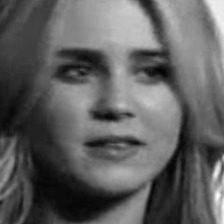

In [16]:
to_pil_transform = torchvision.transforms.ToPILImage()
to_pil_transform(dataset[42][1])

In [17]:
def train_triplet(model, data_loader, num_epochs, lr=0.001):
    model.train()
    loss = torch.nn.TripletMarginLoss()
    loss_history = []
    print(f'lr: {lr}')
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(1, num_epochs+1):
        loss_accum = 0
        loss_cnt = 0
        for xa, xp, xn in tqdm(data_loader, desc=f'train {epoch}/{num_epochs}'):
            ya = model(xa.to(device))
            yp = model(xp.to(device))
            yn = model(xn.to(device))
            loss_data = loss(ya, yp, yn)
            
            optimizer.zero_grad()
            loss_data.backward()
            optimizer.step()
            
            loss_accum += float(loss_data)
            loss_cnt += 1

        loss_value = loss_accum / loss_cnt
        loss_history.append(loss_value)
        print(f'loss: {loss_value}')

        if loss_value > loss_history[-1]:
            lr *= 0.1
            print(f'lr: {lr}')
            optimizer = optim.Adam(model.parameters(), lr=lr)

    return loss_history

In [18]:
import psutil
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=psutil.cpu_count())
psutil.cpu_count()

4

In [24]:
def create_faceid_model():
    model = torchvision.models.resnet50(weights='DEFAULT')
    model.fc = nn.Linear(model.fc.in_features, 16)
    return model

def grayscale_fix_model(model):
    w = model.conv1.weight.data.sum(axis=1).reshape(64, 1, 7, 7)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.conv1.weight.data = w
    return model

def set_trainable(model):
    model.requires_grad_(False)
    model.fc.requires_grad_(True)

def bind_model2device(model):
    model.to(device)
    #model = torch.nn.DataParallel(model, device_ids=devs)

model = create_faceid_model()
model = grayscale_fix_model(model)
set_trainable(model)
bind_model2device(model)
#summary(model)
model.conv1, model.fc

(Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Linear(in_features=2048, out_features=16, bias=True))

In [20]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

In [23]:
device = devs[1]
device

device(type='xla', index=2)

In [25]:
loss_history = train_triplet(model, data_loader, 10)
plt.plot(loss_history)
plt.title('loss');

lr: 0.001


train 1/10:   4%|▍         | 9/237 [04:45<2:00:32, 31.72s/it]


KeyboardInterrupt: 

In [26]:
[torch_xla.core.xla_model.get_memory_info(dev) for dev in devs]

[{'kb_free': 6741952, 'kb_total': 16234496},
 {'kb_free': 13041072, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496}]

In [ ]:
plt.hist(model.fc.weight.cpu().detach().reshape(-1), bins=100);

In [ ]:
model(dataset[42][0].reshape(1, 1, 224, 224).to(device))

In [ ]:
def cos_similarity(v1, v2):
    val = np.inner(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return val.reshape(-1)[0]

def euc_similarity(v1, v2):
    return np.linalg.norm(v1-v2)

In [ ]:
for i in range(10):
    v1 = model(dataset[42][0].reshape(1, 1, 224, 224).to(device)).cpu().detach().numpy()
    v2 = model(dataset[42][1].reshape(1, 1, 224, 224).to(device)).cpu().detach().numpy()
    v3 = model(dataset[42][2].reshape(1, 1, 224, 224).to(device)).cpu().detach().numpy()
    print(euc_similarity(v1, v2), euc_similarity(v1, v3),
          cos_similarity(v1, v2), cos_similarity(v1, v3),
          np.vstack((v1, v2, v3)).min(), np.vstack((v1, v2, v3)).max())

In [21]:
model.requires_grad_(True)
loss_history = train_triplet(model, data_loader, 5, lr=0.00001)
plt.plot(loss_history)
plt.title('loss');

lr: 1e-05


train 1/5:   2%|▏         | 4/237 [04:24<4:16:22, 66.02s/it]


KeyboardInterrupt: 

In [22]:
[torch_xla.core.xla_model.get_memory_info(dev) for dev in devs]

[{'kb_free': 6741952, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496},
 {'kb_free': 15972336, 'kb_total': 16234496}]

In [ ]:
plt.hist(model.fc.weight.cpu().detach().reshape(-1), bins=100);

In [ ]:
model(dataset[42][0].reshape(1, 1, 224, 224))

In [ ]:
model(dataset[42][1].reshape(1, 1, 224, 224))

In [ ]:
model(dataset[42][2].reshape(1, 1, 224, 224))

In [ ]:
for i in range(10):
    v1 = model(dataset[42][0].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    v2 = model(dataset[42][1].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    v3 = model(dataset[42][2].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    print(euc_similarity(v1, v2), euc_similarity(v1, v3),
          cos_similarity(v1, v2), cos_similarity(v1, v3),
          np.vstack((v1, v2, v3)).min(), np.vstack((v1, v2, v3)).max())

In [ ]:
torch.save(model, f'faceid-model-{loss_history[-1]}.pt')
!ls -l faceid-model-*.pt